In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 24.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [1]:
!pip install --upgrade transformers
!pip install transformers peft datasets accelerate sentencepiece
!pip install textaugment optimum[onnxruntime] wandb

  Using cached textaugment-2.0.0-py3-none-any.whl.metadata (12 kB)
  Using cached optimum-1.24.0-py3-none-any.whl.metadata (21 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached googletrans-4.0.2-py3-none-any.whl.metadata (10 kB)
  Using cached onnx-1.17.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (16 kB)
  Using cached onnxruntime-1.21.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (4.5 kB)
  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
  Using cached transformers-4.48.3-py3-none-any.whl.metadata (44 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
Using cached textaugment-2.0.0-py3-none-any.whl (19 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached googletr

In [4]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
from datasets import Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers.trainer_callback import EarlyStoppingCallback

# Load dataset
file_path = "/content/drive/MyDrive/hate/new.xlsx"
df = pd.read_excel(file_path)

# Auto-detect text and label columns
text_col = 'posts' if 'posts' in df.columns else 'text'
label_col = 'labels' if 'labels' in df.columns else 'label'

# Data Cleaning
df = df.dropna(subset=[text_col, label_col])
df[text_col] = df[text_col].astype(str).str.strip()
df = df[df[text_col] != '']

# Split dataset
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df[label_col])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df[label_col])

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Model class with enhanced LoRA configuration
class XMLRWithLoRA(nn.Module):
    def __init__(self, num_labels=3):
        super().__init__()

        # Initialize XLM-RoBERTa model
        self.xmlr = AutoModel.from_pretrained('xlm-roberta-base')

        # Tokenizer
        self.xmlr_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
        if self.xmlr_tokenizer.pad_token is None:
            self.xmlr_tokenizer.pad_token = self.xmlr_tokenizer.eos_token

        # Enhanced LoRA configuration for ~0.45% trainable parameters
        lora_config = LoraConfig(
            r=32,  # Increased rank
            lora_alpha=64,  # Scaled with rank
            target_modules=[
                "query",
                "key",
                "value",
                "intermediate.dense",  # Feed-forward intermediate
                "output.dense"         # Feed-forward output
            ],
            lora_dropout=0.1,
            bias="none",
            task_type="FEATURE_EXTRACTION",
            modules_to_save=["classifier"]  # Make classifier fully trainable
        )

        # Apply LoRA
        self.xmlr = get_peft_model(self.xmlr, lora_config)

        # Classifier (will be fully trainable)
        hidden_size = self.xmlr.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, num_labels)
        )

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids_xmlr=None, attention_mask_xmlr=None, labels=None):
        # Forward pass through XLM-R
        xmlr_outputs = self.xmlr(
            input_ids=input_ids_xmlr,
            attention_mask=attention_mask_xmlr
        )

        # Pooling and classification
        xmlr_pooled = xmlr_outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(xmlr_pooled)

        # Calculate loss if labels provided
        loss = self.loss_fn(logits, labels) if labels is not None else None
        return {'loss': loss, 'logits': logits}

    def tokenize(self, texts, max_length=128):
        # Tokenize texts
        xmlr_inputs = self.xmlr_tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        return {
            'input_ids_xmlr': xmlr_inputs['input_ids'],
            'attention_mask_xmlr': xmlr_inputs['attention_mask']
        }

# Metric computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted'),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted')
    }

# Training configuration
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir='./logs',
    logging_steps=100,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,
    fp16=True,
    gradient_accumulation_steps=2,
    dataloader_num_workers=2,
    remove_unused_columns=False
)

# Data preprocessing
def preprocess_dataset(dataset):
    def process_example(example):
        text = str(example.get(text_col, "")).strip()
        label = int(example.get(label_col, -1))
        return {'text': text, 'label': label}

    return dataset.map(process_example).filter(lambda x: x['text'] != '' and x['label'] != -1)

train_dataset = preprocess_dataset(train_dataset)
val_dataset = preprocess_dataset(val_dataset)
test_dataset = preprocess_dataset(test_dataset)

# Batch collation
def collate_fn(batch):
    texts = [item['text'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    tokenized = model.tokenize(texts)
    return {
        'input_ids_xmlr': tokenized['input_ids_xmlr'],
        'attention_mask_xmlr': tokenized['attention_mask_xmlr'],
        'labels': labels
    }

# Initialize model
model = XMLRWithLoRA(num_labels=len(df[label_col].unique()))

# Print parameter information
print("XLM-RoBERTa with Enhanced LoRA Configuration:")
model.xmlr.print_trainable_parameters()

# Setup trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Training
print("Starting training with enhanced LoRA...")
trainer.train()
print("Training completed!")

# Evaluation
print("\nEvaluating on test set...")
test_results = trainer.evaluate(test_dataset)
print(f"Test results: {test_results}")

# Save model
trainer.save_model("./final_model_enhanced_lora")
print("Model saved to ./final_model_enhanced_lora")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/21000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/21000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4500 [00:00<?, ? examples/s]

XLM-RoBERTa with Enhanced LoRA Configuration:
trainable params: 5,308,416 || all params: 283,352,064 || trainable%: 1.8734
Starting training with enhanced LoRA...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.906100,0.869016,0.606444,0.606079,0.607014,0.606444
2,0.808900,0.741340,0.686444,0.683494,0.690968,0.686444
3,0.725300,0.689353,0.718889,0.716196,0.721262,0.718889
4,0.656300,0.654023,0.730889,0.728066,0.733855,0.730889
5,0.657300,0.633706,0.744222,0.743485,0.744055,0.744222
6,0.609900,0.635544,0.750000,0.748947,0.750089,0.750000
7,0.585700,0.610623,0.748000,0.748172,0.749426,0.748000
8,0.580300,0.623130,0.749111,0.749336,0.750151,0.749111
9,0.556900,0.614710,0.752667,0.752674,0.752982,0.752667


Training completed!

Evaluating on test set...


Test results: {'eval_loss': 0.6148973703384399, 'eval_accuracy': 0.7522222222222222, 'eval_f1': 0.7523423390322133, 'eval_precision': 0.7529306449530538, 'eval_recall': 0.7522222222222222, 'eval_runtime': 14.0077, 'eval_samples_per_second': 321.252, 'eval_steps_per_second': 20.132, 'epoch': 9.992761904761904}
Model saved to ./final_model_enhanced_lora


In [5]:
from sklearn.metrics import classification_report

# Evaluate the model on the test dataset
print("\nEvaluating on test set...")
test_results = trainer.predict(test_dataset)

# Extract predictions and labels
logits = test_results.predictions
labels = test_results.label_ids
predictions = np.argmax(logits, axis=-1)

# Print classification report
print("\nClassification Report:")
print(classification_report(labels, predictions, digits=4))



Evaluating on test set...



Classification Report:
              precision    recall  f1-score   support

           0     0.7281    0.7193    0.7237      1500
           1     0.7347    0.7700    0.7520      1500
           2     0.7960    0.7673    0.7814      1500

    accuracy                         0.7522      4500
   macro avg     0.7529    0.7522    0.7523      4500
weighted avg     0.7529    0.7522    0.7523      4500



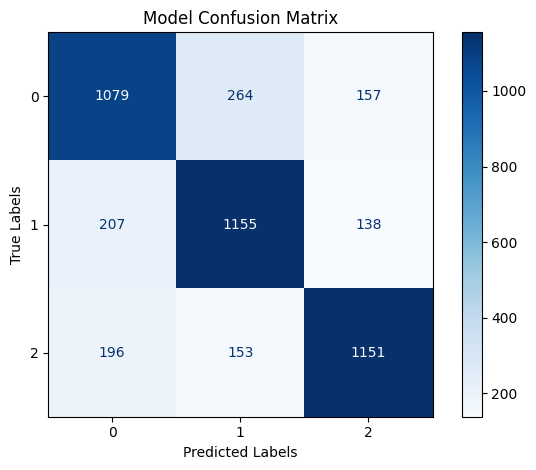

In [11]:
# First get the predictions and true labels
test_results = trainer.predict(test_dataset)
predictions = np.argmax(test_results.predictions, axis=-1)
true_labels = test_results.label_ids

# Generate confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)

# Create and display the plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=sorted(df[label_col].unique()))
disp.plot(cmap='Blues', values_format='d')  # 'd' shows integer values
plt.title('Model Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.grid(False)  # Remove grid lines for cleaner look
plt.tight_layout()
plt.show()

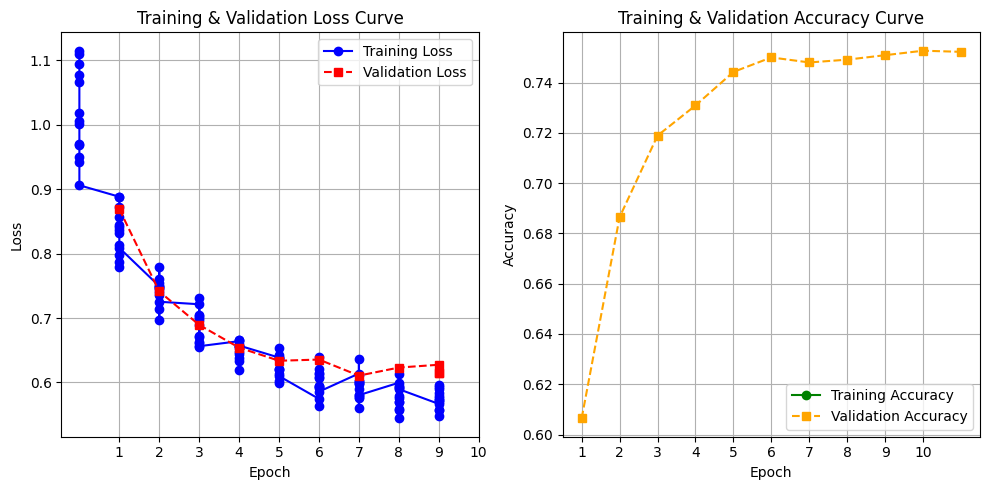

In [13]:
import matplotlib.pyplot as plt

# Extract loss & accuracy values from trainer logs
train_loss, eval_loss = [], []
train_acc, eval_acc = [], []
train_epochs, eval_epochs = [], []

# Keep track of the epoch in a correct manner
current_epoch = 0

for log in trainer.state.log_history:
    if "epoch" in log:
        current_epoch = int(log["epoch"])  # Correct epoch number

    if "loss" in log and "epoch" in log:  # Training loss (once per epoch)
        train_loss.append(log["loss"])
        train_epochs.append(current_epoch)  # Append the correct epoch number

    if "eval_loss" in log and "epoch" in log:  # Validation loss (once per epoch)
        eval_loss.append(log["eval_loss"])
        eval_epochs.append(current_epoch)  # Append the correct epoch number

    if "accuracy" in log:  # Training accuracy (if logged)
        train_acc.append(log["accuracy"])

    if "eval_accuracy" in log:  # Validation accuracy
        eval_acc.append(log["eval_accuracy"])

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # Subplot 1 for loss
plt.plot(train_epochs, train_loss, label="Training Loss", color="blue", marker="o", linestyle="-", markersize=6)
plt.plot(eval_epochs, eval_loss, label="Validation Loss", color="red", marker="s", linestyle="--", markersize=6)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.xticks(range(1, 11))  # Correct x-axis ticks for 10 epochs
plt.legend()
plt.grid()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)  # Subplot 2 for accuracy
plt.plot(range(1, len(train_acc) + 1), train_acc, label="Training Accuracy", color="green", marker="o", linestyle="-", markersize=6)
plt.plot(range(1, len(eval_acc) + 1), eval_acc, label="Validation Accuracy", color="orange", marker="s", linestyle="--", markersize=6)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Curve")
plt.xticks(range(1, 11))  # Correct x-axis ticks for 10 epochs
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



Evaluating on test set...



Classification Report:
              precision    recall  f1-score   support

        Free     0.7281    0.7193    0.7237      1500
        Hate     0.7347    0.7700    0.7520      1500
   Offensive     0.7960    0.7673    0.7814      1500

    accuracy                         0.7522      4500
   macro avg     0.7529    0.7522    0.7523      4500
weighted avg     0.7529    0.7522    0.7523      4500



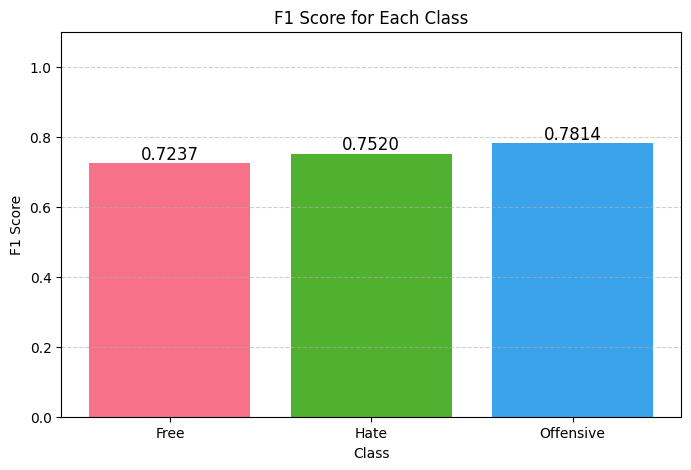

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report

# Evaluate the model on the test dataset
print("\nEvaluating on test set...")
test_results = trainer.predict(test_dataset)

# Extract predictions and labels
logits = test_results.predictions
labels = test_results.label_ids
predictions = np.argmax(logits, axis=-1)

# Print classification report
report = classification_report(labels, predictions, target_names=["Free", "Hate", "Offensive"], output_dict=True)
print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=["Free", "Hate", "Offensive"], digits=4))

# Extract class-wise F1 scores
classes = ["Free", "Hate", "Offensive"]  # Using class names
f1_scores = [report[cls]['f1-score'] for cls in classes]

# Plot F1 scores for each class
plt.figure(figsize=(8, 5))
colors = sns.color_palette("husl", len(classes))  # Different colors for each class
bars = plt.bar(classes, f1_scores, color=colors)

# Add numerical labels above bars
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{score:.4f}", ha='center', va='bottom', fontsize=12)

plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.title("F1 Score for Each Class")
plt.ylim(0, 1.1)  # Ensure visibility of bars
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
